In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import scipy.optimize
import urllib
from typing import Tuple

# Part 1 - Principal Component Analysis [35%]

## Part 1.1 - Implement PCA [15%]

### Restrictions

The use of `sklearn.decomposition.PCA` or `np.cov` is prohibited. You cannot use for loops!! Make sure your operations are vectorized.

In [2]:
def pca(X: np.ndarray, K: int) -> Tuple[np.ndarray, np.ndarray,  np.ndarray]:
    """
    X is an N*D matrix of data (N points in D dimensions)
    K is the desired maximum target dimensionality (K <= min{N,D})

    should return a tuple (P, Z, evals)
    
    where P is the projected data (N*K) where
    the first dimension is the higest variance,
    the second dimension is the second higest variance, etc.

    Z is the projection matrix (D*K) that projects the data into
    the low dimensional space (i.e., P = X * Z).

    and evals, a K dimensional array of eigenvalues (sorted)
    """
    
    N, D = X.shape

    # make sure we don't look for too many eigs!
    if K > N:
        K = N
    if K > D:
        K = D

    ### TODO: YOUR CODE HERE
    miu = np.mean(X, axis=0)
    cov_mat = np.matmul((X - miu).T, X - miu) / (N - 1)
    eig_vals, eig_vecs = np.linalg.eig(cov_mat)
    sort_perm = (-eig_vals).argsort()
    eig_vals = eig_vals[sort_perm][:K]
    eig_vecs = eig_vecs[:, sort_perm][:K]
    Z = eig_vecs
    P = np.matmul(X, Z)
    evals = eig_vals
    

    return (P, Z, evals)

Our first test of PCA will be on Gaussian data with a known covariance matrix. First, let's generate some data and see how it looks.

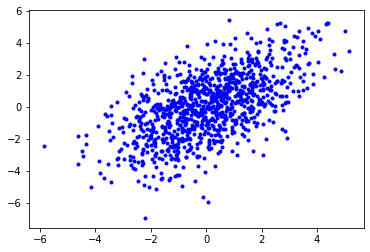

In [3]:
M = np.array([[3,2],[2,4]])
(U,S,VT) = np.linalg.svd(M)
D = np.diag(np.sqrt(S))

Si = U @ D @ VT
x = np.random.randn(1000,2) @ Si
plt.plot(x[:,0], x[:,1], 'b.');

We can also see what the sample covariance is!

In [4]:
np.cov(x.T)

array([[2.90086508, 2.02367383],
       [2.02367383, 3.96660273]])

Note that the sample covariance of the data is almost exactly the true covariance of the data. If you run this with 100,000 data points (instead of 1,000), you should get something even closer to 
$\begin{bmatrix} 3 & 2 \\ 2 & 4 \end{bmatrix}$.

Now, let's run PCA on this data. We basically know what should happen, but let's make sure it happens anyway (still, given the random nature, the numbers won't be exactly the same). We can project the data onto the first eigenvalue and plot it in red, and the second eigenvalue in green. 

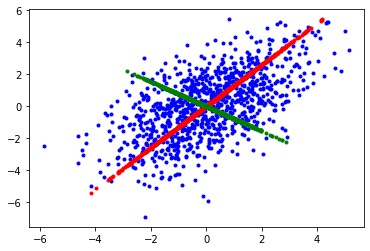

In [5]:
(P, Z, evals) = pca(x, 2)

x0 = (x @ Z[:,0,None]) * Z[:,0,None].T
x1 = (x @ Z[:,1,None]) * Z[:,1,None].T

plt.plot(x[:,0], x[:,1], 'b.', x0[:,0], x0[:,1], 'r.', x1[:,0], x1[:,1], 'g.');

In [6]:
Z[1, :]

array([-0.79203462,  0.61047617])

## Part 1.2 - Visualization of MNIST [5%]

Lets work with some [handwritten digits](https://en.wikipedia.org/wiki/MNIST_database). Before we try PCA on them, let's visualize the digits. Specifically, implement the function `draw_digits`.

It must implement the following specifications:
1. Visualize `K` random samples from `X`, with no repeats.
2. Digits must be visualized on 5 column subplots.
3. A gray colormap must be used to visualize the digits.
4. Add the label of the digit as white text on the upper left corner of the subplot, with font size 16.
5. Remove the axes on the subplot.

In [7]:
np.random.seed(0)

def draw_digits(X: np.ndarray, Y: np.ndarray, K: int = 20):
    ### TODO: YOUR CODE HERE
    N = X.shape[0]
    idx = np.random.choice(N, K, replace=False)
    X_sample = X[idx, :]
    Y_sample = Y[idx]
    
    X_sample = X_sample.reshape((-1, 28, 28)).real
#     print(X_sample[0].shape)
#     print(X_sample.dtype)
    figure, axes = plt.subplots(nrows=K//5, ncols=5)

    i = 0
    for row in axes:
        for col in row:
            col.imshow(X_sample[i].T, cmap='gray')
            col.axis('off')
            col.text(0, 0, Y_sample[i], verticalalignment='top', horizontalalignment='left', color='white', fontsize=16)
            i += 1
        
    plt.show()

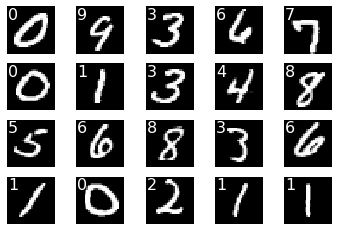

In [8]:
def load_digits():
    X = np.zeros((1000, 784), dtype=float)
    Y = np.zeros((1000,), dtype=int)

    with open('data/digits') as f:
        for idx, line in enumerate(f):
            vals = [int(v) for v in line.split()]
            Y[idx] = vals[0] % 10
            for i in range(len(vals)//2-1):
                X[idx, vals[i*2+1]] = float(vals[i*2+2])
            X[idx,:] = X[idx,:] / np.linalg.norm(X[idx,:])

    return X, Y

X, Y = load_digits()
draw_digits(X, Y)

## 1.3 - Plotting Explained Variance [10%]

Let's examine all the principal components of the digits data.

Plot the explained variance of the principal components, with x-axis being the number of principal components, and the y-axis being the percent variance explained. How many eigenvectors do you have to include before you've accounted for 90% of the variance?
95%? Label these points on your plot.

In [9]:
(P, Z, evals) = pca(X, 784)

Eventually, the eigenvalues drop to zero (note that some may be negative due to floating point errors).

**ANSWER**:

To account for 90% of the variance, we need to include [82, 0.9001006829702769] eigenvectors (labeled in red)
To account for 95% of the variance, we need to include [136, 0.950400061278633] eigenvectors (labeled in blue)


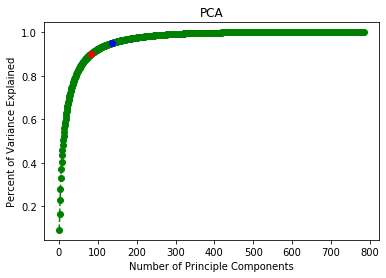

In [10]:
variance = np.trace(np.cov(X.T))

percent_variance_explained = []
sum = 0
marker_90 = 0
marker_95 = 0

for i in range(784):
    sum += np.real(evals[i] / variance)
    if marker_90 == 0 and sum >= 0.9:
        marker_90 = [i + 1, sum]
    if marker_95 == 0 and sum >= 0.95:
        marker_95 = [i + 1, sum]
    percent_variance_explained.append(sum)

print('To account for 90% of the variance, we need to include {} eigenvectors (labeled in red)'.format(marker_90))
print('To account for 95% of the variance, we need to include {} eigenvectors (labeled in blue)'.format(marker_95))

num_PC = [i + 1 for i in range(784)]

# fig=plt.figure()
plt.plot(num_PC, percent_variance_explained, '--go')
plt.plot(marker_90[0], marker_90[1], 'ro')
plt.plot(marker_95[0], marker_95[1], 'bo')
plt.xlabel('Number of Principle Components')
plt.ylabel('Percent of Variance Explained')
plt.title('PCA')

plt.show()

## Part 1.4 - Visualization of Dimensionality Reduction [5%]

Now, let's plot the top 50 eigenvectors:

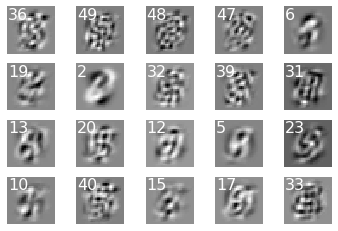

In [11]:
draw_digits(Z.T[:50,:], np.arange(50))

Do these look like digits? Should they? Why or why not?

**ANSWER:** To start with, I would like to point out the the label at the upper left corner denotes the rank of eigenvectors (i.e. 2 means the eigenvector corresponding to the second largest eigenvalue). We can see that for eigenvectors with higher rank, it's easy to recognize the digit, and they should look like digit. For example, the one with label 2 is clearly number 6. This is because eigenvoctors returned by PCA form an orthognormal basis of the digit picture in transformed space. And every digit can be represent as a linear combination of the eigenvectors. In other words, different eigenvectors capture different feature of the digit. Since the eigenvector associated with the highest eigenvalue maximize the variance explained, it captures the most obvious and significant feature of the digit. As a result, it will be very similar to the original digit. But as the rank of the eigenvectors goes lower, it captures more and more subtle features of the digit. Hence it's very difficult to recognize which digit they are representing. Below I sampled out and visualized eigenvectors associated with the ten largest eigenvalue to show it's quite easy to recognize the digit using eigenvectors of higher rank.

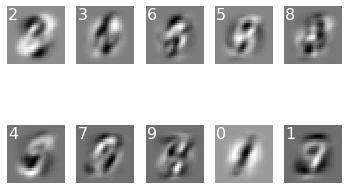

In [12]:
draw_digits(Z.T[:10,:], np.arange(10), 10)

# Part 2 - Softmax Regression [45%]

The goal of this part of the project is to implement Softmax Regression in order to classify the MNIST digit dataset. Softmax Regression is essentially a two-layer neural network where the output layer applies the Softmax cost function, a multiclass generalization of the logistic cost function.

In logistic regression, we have a hypothesis function of the form

$$\mathbb{P}[y=1] = \frac{1}{1 + e^{-wx}}$$

where $\mathbf{w}$ is our weight vector. Like the hyperbolic tangent function, the logistic function is also a sigmoid function with the characteristic 's'-like shape, though it has a range of $(0, 1)$ instead of $(-1, 1)$. Note that this is technically not a classifier since it returns probabilities instead of a predicted class, but it's easy to turn it into a classifier by simply choosing the class with the highest probability.

Since logistic regression is used for binary classification, it is easy to see that:

$$\begin{aligned}
\mathbb{P}[y=1] &= \frac{1}{1 + e^{-wx}} \\
&= \frac{e^{wx}}{e^{wx} + e^{0 \cdot x}} \\
\end{aligned}$$

Similarily,

$$\begin{aligned}
\mathbb{P}[y=0] &= 1 - \mathbb{P}[y=1] \\
&= 1 - \frac{e^{wx}}{1 + e^{wx}} \\
&= \frac{e^{0 \cdot x}}{e^{wx} + e^{0 \cdot x}} \\
\end{aligned}$$

From this form it appears that we can assign the vector $w_1 = w$ as the weight vector for class $1$ and $w_0 = \vec{0}$ as the weight vector for class $0$. This motivates generalization to classification with more than 2 classes. By assigning a separate weight vector $w_i$ to each class, for each example $x$ we can predict the probability that it is class $i$, and again we can classify by choosing the most probable class.

$$\mathbb{P}[y=i] = \frac{e^{w_i x}}{\sum\limits_j e^{w_j x}}$$

A more compact way of representing the values $w_i x$ is $Wx$ where each row $i$ of $W$ is $w_i$. We can also represent a dataset $\{x_i\}$ with a matrix $X$ where each column is a single example, resulting in $WX$.

## Part 2.1 - Questions [5%]

For both problems, assume there are $C$ classes, $n$ be the number of samples, and $d$ be the number of features for each sample. 

1. Prove that the probabilities outputed by the softmax function sum to 1. 

**ANSWER**: $$\sum ^{N}_{i=1}P\left[ y=i\right] =\sum ^{N}_{i=1}\dfrac {e^{w_{i}x}}{\sum ^{N}_{j=1}e^{w_{j}x}}=\dfrac {\sum ^{N}_{i=1}e^{\omega _{i}x}}{\sum ^{N}_{j=1}e^{w_{j}x}}=1$$

2. Given the description of matrices $W$, $X$ above, what are the dimensions of $W$, $X$, and $WX$? 

**ANSWER**: 

dimension of $W$: $C\times d$

dimension of $X$: $d\times n$

dimension of $WX$: $C\times n$

## Part 2.2 - Implementing a Softmax Classifier [20%]
We can also train on this model with an appropriate loss function. The Softmax loss function is given by

$$\xi(W) = -\sum\limits_{i=1}^{n}\sum\limits_{j=1}^{C}\delta_{y_i,j}\log \mathbb{P}(y_i = j)$$

where $n$ is the number of samples, $C$ is the number of classes, $\delta_{y_i,j}$ is the [kronecker delta](https://en.wikipedia.org/wiki/Kronecker_delta), $y_i$ is the label of sample $i$, and $\mathbb{P}(y_i = j)$ is calculated using a softmax function using the weights from matrix $W$.

Note that 

$$\delta_{y_i,j} = \begin{cases}1 &\text{if } y_i = j \\ 0 & \text{if } y_i \neq j\end{cases}$$

The gradient of this function is given by 

$$\nabla_{\vec{w_j}} \xi(W) = \sum_{i=1}^{n}{ \left[ x_i \left( \mathbb{P}[y_i = j] - \delta_{y_i, j} \right) \right]}$$

The derivation for this can be found in the references. Note that the kronecker delta and the probabilities can be represented as matrices, which makes the code for the loss and the gradient very simple.

You cannot use for loops!! Make sure your operations are vectorized.

In [13]:
class SoftmaxRegression:
    """
    Here you will fill in this incomplete implementation of Softmax regression.

    Adapted from code by Jatin Shah
    """
    def __init__(self, num_classes, ex_size, opts={'maxIter':400}):
        """
        num_classes:    number of possible classifications
        ex_size:        size of attribute array (number of input features)
        reg:            regularizing term coefficient (lambda)
        opts:           in this class the only option used is maxIter
        """

        self.num_classes = num_classes
        self.ex_size = ex_size
        self.opts = opts

        # Initialize weight matrix with empty matrix
        self.W = np.zeros((num_classes, ex_size))


    def cost(self, X, Y, W=None):
        """
        Calculate the cost function for X and Y using current weight matrix W. Note that we are not using
        a regularizer in the cost; this is equivalent to lambda = 0.

        X:              (M x N) matrix of input feature values,
                            where M = ex_size, N = number of examples
        Y:              (N x 1) array of expected output classes for each example

        Returns the cost and its gradient, which is the form needed to use scipy.optimize.minimize
        """

        if W is None:
            W = this.W
        num_classes = self.num_classes
        ex_size = self.ex_size

        W = W.reshape(num_classes, ex_size)         # Ensure W is in the correct dimensions
        N = X.shape[1]                              # N = number of examples

        W_X = W.dot(X)                              # This is our activation matrix with dimensions (A * B)
                                                    # where A is the number of classes and B is the number
                                                    # of examples. (W_X[a, b] gives the activation of example
                                                    # b for class a.) You will use this matrix to find the
                                                    # probabilities that example b is class a using the
                                                    # softmax formula.
        
        
        ## DELETE BELOW 
#         print('Number of examples: {}'.format(N))
#         print('Shape of X: {}'.format(X.shape))
#         print('Shape of Y: {}'.format(Y.shape))
#         print('Shape of W: {}'.format(W.shape))
#         print('Shape of W_X: {}'.format(W_X.shape))

        W_X = W_X - np.amax(W_X)

        # This is the indicator function used in the loss function, where indicator[a, b] = 1
        # when example b is labeled a (according to the target Y) and indicator[a, b] = 0 otherwise.

        indicator = scipy.sparse.csr_matrix((np.ones(N), (Y, np.array(range(N)))))
        indicator = np.resize(np.array(indicator.todense()), (num_classes, N))


        # Each row of W_X is the set of activations for each class corresponding to
        # one example; the probabilties are given by the exponential of each entry
        # divided by the sum of the exponentials over the entire column.

        # The cost associated with a single example is given by -1 times the log probability
        # of the true class; initialize the cost variable to the AVERAGE cost over all the examples.
        # Hint: there's an easy way to do this with the indicator matrix.

        # The gradient has the same dimensions as W, and each component (i,j) represents the
        # derivative of the cost with respect to the weight associated with class i, attribute j.
        # The gradient associated with a single example x is given by A * x_T, where x_T is
        # the transpose of the example, and A is a vector with component i given by (P(class = i) - 1)
        # if the true class is i, and (P(class = i)) otherwise. Notice that this multiplication gives
        # the desired dimensions. Find the AVERAGE gradient over all the examples. Again, there is
        # an easy way to do this with the indicator matrix.

        # TODO: Compute the predicted probabilities, the total cost, and the gradient.

        ### YOUR CODE HERE ###
        
        softmax = lambda x: np.exp(x) / np.exp(x).sum(axis=0)
        probabilities = softmax(W_X)
        cost = - 1/N * (np.log(probabilities) * indicator).sum()
        gradient = 1/N * (probabilities - indicator).dot(X.T)


        ### YOUR CODE (ENDS) HERE ###

        # flatten is needed by scipy.optimize.minimize
        return cost, gradient.flatten()


    def train(self, X, Y):
        """
        Train to find optimal weight matrix W. Here we make use of the SciPy optimization library but
        in theory you could implement gradient descent to do this as well.

        X:              (M x N) matrix of input feature values,
                            where M = ex_size, N = number of examples
        Y:              (N x 1) array of expected output classes for each example
        maxIter:        Maximum training iterations
        """

        num_classes = self.num_classes
        ex_size = self.ex_size
        W = self.W

        # Set maxIter hyperparameter
        if self.opts['maxIter'] is None:
            self.opts['maxIter'] = 400

        # Lambda function needed by scipy.optimize.minimize
        J = lambda w: self.cost(X, Y, w)

        result = scipy.optimize.minimize(J, W, method='L-BFGS-B', jac=True, options={'maxiter': self.opts['maxIter'], 'disp': True})
        self.W = result.x # save the optimal solution found

    def predict(self, X):
        """
        Use W to predict the classes of each example in X.

        X:              (M x N) matrix of input feature values,
                            where M = ex_size, N = number of examples

        """

        W = self.W.reshape(self.num_classes, self.ex_size)
        W_X = W.dot(X)

        # TODO: Compute the predicted probabilities and the predicted classes for each example
        # Reminder: The predicted class for a single example is just the one with the highest probability

        ### YOUR CODE HERE ###

        softmax = lambda x: np.exp(x) / np.exp(x).sum(axis=0)
        probabilities = softmax(W_X)
        predicted_classes = np.argmax(probabilities, axis=0)

        ### YOUR CODE (ENDS) HERE ###

        return predicted_classes

You can test your implementation of `SoftmaxRegression` by running the following snippet below:

In [14]:
def good_job(path):
    a = plt.imread(urllib.request.urlopen(path))
    fig = plt.imshow(a)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.show()

def loadMNIST(image_file, label_file):
    """
    returns a 28x28x[number of MNIST images] matrix containing
    the raw MNIST images
    :param filename: input data file
    """

    with open(image_file, "r") as f:
        magic = np.fromfile(f, dtype=np.dtype('>i4'), count=1)

        num_images = np.fromfile(f, dtype=np.dtype('>i4'), count=1)[0]
        num_rows = np.fromfile(f, dtype=np.dtype('>i4'), count=1)[0]
        num_cols = np.fromfile(f, dtype=np.dtype('>i4'), count=1)[0]

        exSize = num_rows * num_cols
        images = np.fromfile(f, dtype=np.ubyte)
        images = images.reshape((num_images, exSize)).transpose()
        images = images.astype(np.float64) / 255

    with open(label_file, 'r') as f:
        magic = np.fromfile(f, dtype=np.dtype('>i4'), count=1)
        num_labels = np.fromfile(f, dtype=np.dtype('>i4'), count=1)
        labels = np.fromfile(f, dtype=np.ubyte)

    return images, labels

ex_size = 28*28   # size of MNIST digits
num_classes = 10  # 10 digits to classify

X, Y = loadMNIST('data/train-images.idx3-ubyte', 'data/train-labels.idx1-ubyte')
testX, testY = loadMNIST('data/t10k-images.idx3-ubyte', 'data/t10k-labels.idx1-ubyte')


Accuracy: 92.25
TEST PASSED!!!


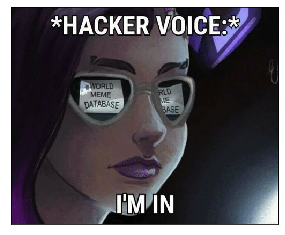

In [15]:
sm = SoftmaxRegression(num_classes, ex_size)
sm.train(X, Y)

predictions = sm.predict(testX)
assert predictions.shape == testY.shape, "predictions and testY must have the same shape!"
accuracy = 100 * np.sum(predictions == testY, dtype=np.float64) / testY.shape[0]
print(f"Accuracy: {accuracy:.2f}")
assert accuracy >= 92, "Your implementation is sadly incorrect :("

print("TEST PASSED!!!")
good_job("https://www.cs.umd.edu/~tomg/img/important_memes/hacker_database.png")

## Part 2.3 - Stability [10%]

In the `cost` function of `SoftmaxRegression`, we see the line

```python3
W_X = W_X - np.amax(W_X)
```

1. What is this operation doing?

**ANSWER**: find the maximum value in W_X, then subtract every element in the matrix by this maximum value

2. Show that this does not affect the predicted probabilities.

**ANSWER**: We know that $\mathbb{P}[y=i] = \frac{e^{w_i x}}{\sum\limits_j e^{w_j x}}$. By subtracting every element in $x$ with a constant, we are actually performing $\frac{e^ce^{w_i x}}{e^c\sum\limits_j e^{w_j x}}$. Since we are simply multiplying the numerator and the denominator with the same constant, this does not affect the predicted probabilities

3. Why might this be an optimization? Justify your answer.

**ANSWER**: We notice that in $\mathbb{P}[y=i] = \frac{e^{w_i x}}{\sum\limits_j e^{w_j x}}$, we performed an exponential operation, which will result in a very large number and will pose issue on the stability or precision of the result (i.e. overflow). To avoid such issue, we could subtract every element in the matrix with the maximum value in the matrix, so that the new matrix will only have zero and negative values. The result calculated using the new matrix will be more precise

## 2.4 - Analysis of Classifier Accuracy [10%]

Plot the accuracy of the classifier as a function of the number of examples seen.
Do you observe any overfitting or underfitting? Discuss and expain what you observe. Use the helper functions provided below.

In [16]:
def train_test(classifier, X, Y, Xtest, Ytest):
    """
    Train a classifier on data (X,Y) and evaluate on
    data (Xtest,Ytest).  Return a tuple of:
      * Training data accuracy
      * Test data accuracy
    """
    classifier.train(X, Y)
    train_acc = np.mean(Y == classifier.predict(X))
    test_acc = np.mean(Ytest == classifier.predict(Xtest))

    print(f"Training accuracy {train_acc}, test accuracy {test_acc}")

    return train_acc, test_acc

def learning_curve(classifier, X, Y, Xtest, Ytest):
    """
    Generate a learning curve by repeatedly halving the amount of
    training data until none is left.

    We return a triple containing:
      * The sizes of data sets we trained on
      * The training accuracies at each level
      * The test accuracies at each level
    """

    N = X.shape[1]                   # how many total points?
    M = int(np.ceil(np.log2(N)))     # how many classifiers will we have to train?

    data_sizes = np.zeros(M)
    train_accs  = np.zeros(M)
    test_accs   = np.zeros(M)

    for i in range(1, M+1):
        # select every 2^(M-i)th point
        ids = np.arange(0, N, 2**(M-i))
        Xtr = X[:, ids]
        Ytr = Y[ids]

        # report what we're doing
        print(f"Training classifier on {ids.size} points...")

        # train the classifier
        train_acc, test_acc = train_test(classifier, Xtr, Ytr, Xtest, Ytest)

        # store the results
        data_sizes[i-1] = ids.size
        train_accs[i-1] = train_acc
        test_accs[i-1]  = test_acc

    return (data_sizes, train_accs, test_accs)

**ANSWER**:

In [17]:
import warnings
warnings.filterwarnings('ignore')
data_sizes, train_accs, test_accs = learning_curve(SoftmaxRegression(num_classes, ex_size), X, Y, testX, testY)

Training classifier on 2 points...
Training accuracy 1.0, test accuracy 0.1139
Training classifier on 4 points...
Training accuracy 1.0, test accuracy 0.1437
Training classifier on 8 points...
Training accuracy 1.0, test accuracy 0.2692
Training classifier on 15 points...
Training accuracy 1.0, test accuracy 0.3502
Training classifier on 30 points...
Training accuracy 1.0, test accuracy 0.4004
Training classifier on 59 points...
Training accuracy 1.0, test accuracy 0.5819
Training classifier on 118 points...
Training accuracy 1.0, test accuracy 0.7018
Training classifier on 235 points...
Training accuracy 1.0, test accuracy 0.793
Training classifier on 469 points...
Training accuracy 1.0, test accuracy 0.815
Training classifier on 938 points...
Training accuracy 1.0, test accuracy 0.8432
Training classifier on 1875 points...
Training accuracy 1.0, test accuracy 0.858
Training classifier on 3750 points...
Training accuracy 1.0, test accuracy 0.8486
Training classifier on 7500 points...


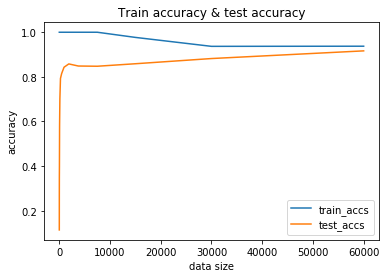

In [18]:
plt.plot(data_sizes, train_accs, label = "train_accs")
# line 2 points
x2 = [10,20,30]
y2 = [40,10,30]
plt.plot(data_sizes, test_accs, label = "test_accs")
plt.xlabel('data size')
plt.ylabel('accuracy')
plt.title('Train accuracy & test accuracy')
plt.legend()
plt.show()

Initially, the classifier is overfitting significantly as we have a very small sample and relative powerful classifier. The classifier can perfectly fit the training data and produce a nearly 100% training accuracy. But this is not what we want because the classifier fails to generalize well, so that the test accuracy is very poor. As we start to increase the sample size(data_size), we can see that the classifier can no longer fit the training data perfectly and that it starts to predict the test data better. This is a good sign as the classifier is learning to generalize prediction. This is because we have fed more data to the classifier so that it is able to learn more patterns in the data distribution. Finally we can see that the train_accs and test_accs are almost the same, this shows that our classifier is doing well but it's still overfitting the training data slightly.

# Part 3 - Deep Learning Software [20%]

We'll examine the use of software packages for deep learning, focusing on TensorFlow and PyTorch.

1. [Watch this lecture from Stanford](https://www.youtube.com/watch?v=6SlgtELqOWc).
2. Read the papers on [TensorFlow](http://download.tensorflow.org/paper/whitepaper2015.pdf) and [PyTorch](https://openreview.net/pdf?id=BJJsrmfCZ).

Summarize the lecture and each of the papers. Some points that you may discuss are listed below. Note that this list is not comprehensive.

- What is difference between CPU and GPU?
- What are benefits that these machine learning libraries offer?
- What is the difference between static and dynamic computational graphs?
- How gradient computation is done in these frameworks?
- Which framework would you use and why?

**ANSWER**:
To examine the software we use for deep learning, we will start with the underlying infrastructure where the softwares are built on. GPU(Graphic Processing Unit) and CPU(Central Processing Unit) are probably the two most popular hardware used for deep learning (probably FPGA and ASIC as well). Between the two processing units, GPUs are obviously a better choice for those who have access to them, as it's designed to be good at parallel computation by nature. GPUs, compared to CPUs, encapsulate more cores (usually up to 3000+) in one unit, and each core is far less powerful than the one in CPUs. CPUs, on the contracy, have fewer cores (usually up to 8), and each core is running at a higher frequency hence more powerful than cores in GPUs. Building upon the GPUs are the libraries used to realize parallel computation. There are two main libraries, CUDA, which is only available for Nvidia GPUs, and OpenCL, which is open-source. For now, the mainstream libraries of deep learning still mostly run on CUDA and Nvidia GPUs, as it offers the best performance.

Though CUDA is a powerful tool, it's not easy to write deep learning algorithms using it directly. To tackle this issue, researchers and engineers developed libraries for people to write algorithm efficiently, without worrying about the underlying execution of the code. Some of the most popular libraries are PyTorch and Tensorflow (and probably MXNet). These libraries help us take care of the execution of our code, so that we get to write high-level imperative code and don't have to worry about how the machine runs them (except for vectorization). With the help of these libraries, people can develop deep learning algorithms or softwares more efficiently at a faster pace.

Now we'll focus on the two most popular deep learning libraries, PyTorch and Tensorflow. Although both of them are as popular, their design and style are very different. Specifically, PyTorch builds a dynamic computational graph, while Tensorflow builds a static computational graph. Static computational graph, as its name indicates, are built before the actual training. In Tensorflow, we need to declare each node and edge (typically referred as Tensor) before we feed the data into the network. After we have built such graph, we start a "session" and proceed to actual training. Static computational graph have its advantages. For example, since the graph is built beforehand, the machine can pre-optimize the computation and the graph can be used multiple times with different input (of same dimension). Moreover, static graphs can be executed across multiple machine and achieve a higher level of parallelism. However, typically it's very difficult to build a complicated static computational graph. One need to consider many aspects (i.e. shape of input) to design such a graph. And its static nature makes it very difficult to debug. Dynamic computational graph, which is used by PyTorch, though lacks the advantage of static graph, are far more natural to write and possess a more "Pythonic" style (An example would be conditional statements). it's built and run at the same time so that can be modified dynamically. Such nature made it a more popular choice in research field in recent years.

We all know that one of the essential but arduous tasks in deep learning is to compute the gradient. Deep learning frameworks help us tackle this with some magic called Autograd. Actually, the underlying magic of autograd is just chain rule. Take DCG for example, in the forwarding stage, gradient is calculated for each operation. As a result, whenever we want to request the gradient for a specific complex operation, the Autograd engine will tracing the graph from the root to the leaf and multiplying every gradient in the way using the chain rule. With the help of Autograd, more complex algorithms can be deisgned and solved.

Personally, I have experience with both libraries and found that PyTorch is easier to use. It's more pythonic style makes it easier to write and whenever I make a mistake, it's also easier to track and fix it. However, I also noticed that recently Tensorflow has been promoting its Keras wrapper and eager mode. I'm also willing to give it a shot.